#git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402

/content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402


In [ ]:
!git config --global user.email 'robosun78@korea.ac.kr'
!git config --global user.name 'robosun78'

In [ ]:
!ls

FinalProject  HW1  HW2	HW3  HW4  README.md


In [ ]:
!git add FinalProject

In [ ]:
!git commit -m 'CLIP&DINOv2&Vit similarity'
!git push

[main fd0c420] CLIP&DINOv2&Vit similarity
 4 files changed, 1 insertion(+), 1 deletion(-)
 rewrite FinalProject/Final_proejct_2022320027.ipynb (67%)
 create mode 100644 FinalProject/clip.index
 create mode 100644 FinalProject/dino.index
 create mode 100644 FinalProject/vit.index
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 36.93 MiB | 9.56 MiB/s, done.
Total 7 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/robosun78/20242R0136COSE47402.git
   88d1f70..fd0c420  main -> main


#Code

In [ ]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 94.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [ ]:
import torch
import torchvision
from transformers import AutoModel, AutoImageProcessor
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import faiss
from tqdm import tqdm
import pandas as pd
import random

random.seed(42)
save_route = "/content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402/FinalProject/"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Model

In [ ]:
from transformers import AutoProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
from transformers import AutoImageProcessor, AutoModel

dino_model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

In [ ]:
from transformers import AutoImageProcessor, ViTModel

vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

## Dataset

### kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hmendonca/disc21")

print("Path to dataset files:", path)

100%|██████████| 31.7G/31.7G [07:15<00:00, 78.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4


### Dataframe

In [ ]:
data_df = pd.read_csv("/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_ground_truth.csv")

data_df = pd.DataFrame({
    "query": ["Q50017"] + data_df['Q50017'].tolist(),
    "reference": ["R277156"] + data_df['R277156'].tolist()
})

In [ ]:
data_df

,query,reference
0,Q50017,R277156
1,Q50019,R294758
2,Q50025,R922600
3,Q50034,R360860
4,Q50036,R105649
...,...,...
9995,Q99970,R263204
9996,Q99972,R336410
9997,Q99973,R759408
9998,Q99975,R726991


In [ ]:
query_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_queries/images/final_queries"
reference_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references"

In [ ]:
data_df['numeric_reference'] = data_df['reference'].str.extract(r'R(\d+)').astype(int)
filtered_df = data_df[data_df['numeric_reference']<50000]

In [ ]:
query_list = filtered_df['query'].tolist()

In [ ]:
num_list = filtered_df['numeric_reference'].tolist()
full_list = [i for i in range(0,50000)]
full_list = list(set(full_list)-set(num_list))
sampled_list = random.sample(full_list, 4500)
reference_num = sampled_list +num_list

reference_list = ["R"+str(number).zfill(6) for number in reference_num]

In [ ]:
filtered_df

,query,reference,numeric_reference
12,Q50060,R003513,3513
19,Q50095,R029638,29638
34,Q50186,R038042,38042
44,Q50229,R040485,40485
77,Q50386,R037975,37975
...,...,...,...
9909,Q99525,R030731,30731
9912,Q99538,R043554,43554
9956,Q99763,R034725,34725
9985,Q99915,R044043,44043


In [ ]:
filtered_df=filtered_df.reset_index()
final_df = filtered_df[["query", "reference"]]

### Dataloader

In [ ]:
def query_dataloader(processor):
  query_images = []
  for file in tqdm(query_list):
      image = Image.open(os.path.join(query_folder_path,file+'.jpg'))
      image = processor(images = image, return_tensors="pt").pixel_values
      query_images.append(image)
  query_loader = torch.utils.data.DataLoader(query_images, batch_size=32)
  return query_loader

def reference_dataloader(processor):
  reference_images = []
  for file in tqdm(reference_list):
      image = Image.open(os.path.join(reference_folder_path,file+'.jpg'))
      image = processor(images = image, return_tensors="pt").pixel_values
      reference_images.append(image)
  reference_loader = torch.utils.data.DataLoader(reference_images, batch_size=32)
  return reference_loader

#image embeddings&FAISS

In [ ]:
def normalizeL2(embeddings):
    vector = embeddings.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    return vector

def make_embeddings(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

##CLIP

In [ ]:
clip_reference = reference_dataloader(clip_processor)

100%|██████████| 5000/5000 [02:02<00:00, 40.95it/s]


In [ ]:
index_clip = faiss.IndexFlatL2(512)

In [ ]:
for img in tqdm(clip_reference):
    img = img.to(device).squeeze()
    clip_features = clip_model.get_image_features(img)
    make_embeddings(clip_features,index_clip)

100%|██████████| 157/157 [00:58<00:00,  2.68it/s]


In [ ]:
faiss.write_index(index_clip,save_route+"clip.index")

## DinoV2

In [ ]:
index_dino = faiss.IndexFlatL2(768)

In [ ]:
dino_reference = reference_dataloader(dino_processor)

100%|██████████| 5000/5000 [03:07<00:00, 26.63it/s]


In [ ]:
for img in tqdm(dino_reference):
    img = img.to(device).squeeze()
    dino_features = dino_model(img).last_hidden_state.mean(dim=1)
    make_embeddings(dino_features,index_dino)

100%|██████████| 157/157 [01:16<00:00,  2.06it/s]


In [ ]:
faiss.write_index(index_dino,save_route+"dino.index")

## ViT

In [ ]:
index_vit = faiss.IndexFlatL2(768)

In [ ]:
vit_reference = reference_dataloader(vit_processor)

100%|██████████| 5000/5000 [01:09<00:00, 72.45it/s]


In [ ]:
for img in tqdm(vit_reference):
    img = img.to(device).squeeze()
    vit_features = vit_model(img).last_hidden_state[:, 0, :].squeeze()
    make_embeddings(vit_features,index_vit)

100%|██████████| 157/157 [00:55<00:00,  2.82it/s]


In [ ]:
 faiss.write_index(index_vit,save_route+"vit.index")

### Simiarity

## test

In [ ]:
test_img='/content/CAR_IMAGE.jpg'
test_img = Image.open(test_img)

In [ ]:
#dino_features = extract_features_dino(test_img)
#image_features_dino = normalizeL2(dino_features)
#print(test_img.shape)
clip_features = extract_features_clip(test_img)
image_features_clip = normalizeL2(clip_features)
#vit_features = extract_features_vit(test_img)
#image_features_vit = normalizeL2(vit_features)

In [ ]:
index_clip = faiss.read_index("clip.index")
#index_dino = faiss.read_index("dino.index")
#index_vit = faiss.read_index("vit.index")

In [ ]:
index_clip.ntotal

500

In [ ]:
#d_dino,i_dino = index_dino.search(image_features_dino,5)
d_clip,i_clip = index_clip.search(image_features_clip,5)
#d_vit,i_vit = index_vit.search(image_features_vit,5)

In [ ]:
for idx, dist in zip(i_clip[0], d_clip[0]):
  print(idx)
  print(reference_list[idx], dist)

195
R046404 0.82766926
267
R011012 0.9006485
478
R045322 0.90620005
488
R019363 0.9105289
171
R029527 0.9157551


In [ ]:
len(reference_list)

500

In [ ]:
retrieved_images = [
    {"path": os.path.join(reference_folder_path,reference_list[idx]+'.jpg'), "similarity": 100 - dist* 100} for idx, dist in zip(i_clip[0], d_clip[0])
]

In [ ]:
retrieved_images

[{'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R046404.jpg',
  'similarity': 17.233073711395264},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R011012.jpg',
  'similarity': 9.935152530670166},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R045322.jpg',
  'similarity': 9.379994869232178},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R019363.jpg',
  'similarity': 8.947110176086426},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R029527.jpg',
  'similarity': 8.424490690231323}]

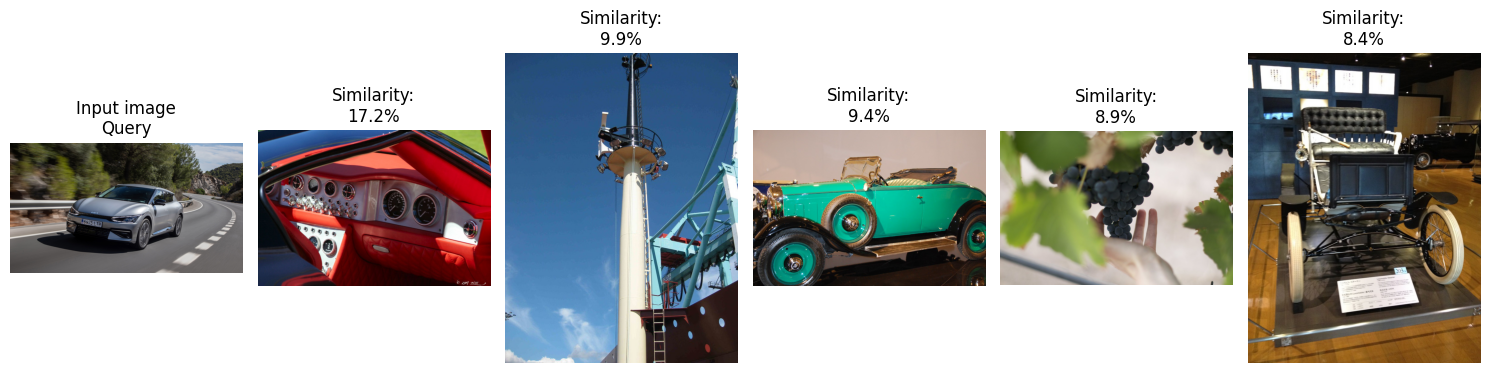

## Evaluate simiarity performance of the model

### CLIP

In [ ]:
clip_query = query_dataloader(clip_processor)

100%|██████████| 500/500 [00:08<00:00, 56.53it/s]


In [ ]:
clip_distance_list = np.empty((0, 3))
clip_index_list=np.empty((0, 3))

for img in tqdm(clip_query):
    img = img.to(device).squeeze()
    features = clip_model.get_image_features(img)
    image_features = normalizeL2(features)
    index_clip = faiss.read_index(save_route+"clip.index")
    d_clip,i_clip = index_clip.search(image_features,3)
    clip_distance_list = np.concatenate((clip_distance_list,d_clip), axis=0)
    clip_index_list = np.concatenate((clip_index_list,i_clip), axis=0)

100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


In [ ]:
clip_correct_top3 =[]
clip_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in clip_index_list[i]]:
    clip_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(clip_index_list[i][0])]:
    clip_correct.append(i)

In [ ]:
len(clip_correct_top3), len(clip_correct)

(206, 176)

### DINOv2

In [ ]:
dino_query = query_dataloader(dino_processor)

100%|██████████| 500/500 [00:19<00:00, 26.04it/s]


In [ ]:
dino_distance_list = np.empty((0, 3))
dino_index_list=np.empty((0, 3))

for img in tqdm(dino_query):
    img = img.to(device).squeeze()
    features = dino_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_dino = faiss.read_index(save_route+"dino.index")
    d_dino,i_dino = index_dino.search(image_features,3)
    dino_distance_list = np.concatenate((dino_distance_list,d_dino), axis=0)
    dino_index_list = np.concatenate((dino_index_list,i_dino), axis=0)

100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


In [ ]:
dino_correct_top3 =[]
dino_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in dino_index_list[i]]:
    dino_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(dino_index_list[i][0])]:
    dino_correct.append(i)

In [ ]:
len(dino_correct_top3), len(dino_correct)

(332, 309)

### ViT

In [ ]:
vit_query = query_dataloader(vit_processor)

In [ ]:
vit_distance_list = np.empty((0, 3))
vit_index_list=np.empty((0, 3))

for img in tqdm(vit_query):
    img = img.to(device).squeeze()
    features = vit_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_vit = faiss.read_index(save_route+"vit.index")
    d_vit,i_vit = index_vit.search(image_features,3)
    vit_distance_list = np.concatenate((vit_distance_list,d_vit), axis=0)
    vit_index_list = np.concatenate((vit_index_list,i_vit), axis=0)

100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


In [ ]:
vit_correct_top3 =[]
vit_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in vit_index_list[i]]:
    vit_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(vit_index_list[i][0])]:
    vit_correct.append(i)

In [ ]:
len(vit_correct_top3), len(vit_correct)

(233, 206)

### Combination of models

In [ ]:
clip_distance_list = np.empty((0, 5000))
clip_index_list=np.empty((0, 5000))

for img in tqdm(clip_query):
    img = img.to(device).squeeze()
    features = clip_model.get_image_features(img)
    image_features = normalizeL2(features)
    index_clip = faiss.read_index(save_route+"clip.index")
    d_clip,i_clip = index_clip.search(image_features,5000)
    clip_distance_list = np.concatenate((clip_distance_list,d_clip), axis=0)
    clip_index_list = np.concatenate((clip_index_list,i_clip), axis=0)

In [ ]:
dino_distance_list = np.empty((0, 5000))
dino_index_list=np.empty((0, 5000))

for img in tqdm(dino_query):
    img = img.to(device).squeeze()
    features = dino_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_dino = faiss.read_index(save_route+"dino.index")
    d_dino,i_dino = index_dino.search(image_features,5000)
    dino_distance_list = np.concatenate((dino_distance_list,d_dino), axis=0)
    dino_index_list = np.concatenate((dino_index_list,i_dino), axis=0)

In [ ]:
vit_distance_list = np.empty((0, 5000))
vit_index_list=np.empty((0, 5000))

for img in tqdm(vit_query):
    img = img.to(device).squeeze()
    features = vit_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_vit = faiss.read_index(save_route+"vit.index")
    d_vit,i_vit = index_vit.search(image_features,5000)
    vit_distance_list = np.concatenate((vit_distance_list,d_vit), axis=0)
    vit_index_list = np.concatenate((vit_index_list,i_vit), axis=0)

In [ ]:
avg_list=[]

In [ ]:
for i in range(len(query_list)):
    clip_df = pd.DataFrame({"index": clip_index_list[i], "score": clip_distance_list[i]})
    dino_df = pd.DataFrame({"index": dino_index_list[i], "score": dino_distance_list[i]})
    vit_df = pd.DataFrame({"index": vit_index_list[i], "score": vit_distance_list[i]})

    merged_df = pd.merge(dino_df, clip_df,vit_df on="index", suffixes=("_dino", "_clip","_vit"))

    merged_df["avg_score"] = (merged_df["score_dino"] + merged_df["score_clip"]+merged_df["score_vit"]) / 3

    merged_df["path"] = merged_df["index"].apply(lambda idx: image_paths[idx])
    print("Merged Scores")
    print(merged_df.head())

    sorted_df = merged_df.sort_values(by="avg_score", ascending=True)
    print("Sorted Scores")
    print(sorted_df.head())
    top_3_index = sorted_df.iloc[:3]["index"].tolist()
    avg_list.append(top_3_index)

In [ ]:
avg_correct_top3 =[]
avg_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in avg_index_list[i]]:
    avg_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(avg_index_list[i][0])]:
    avg_correct.append(i)

### Visualize

#### compare the performance

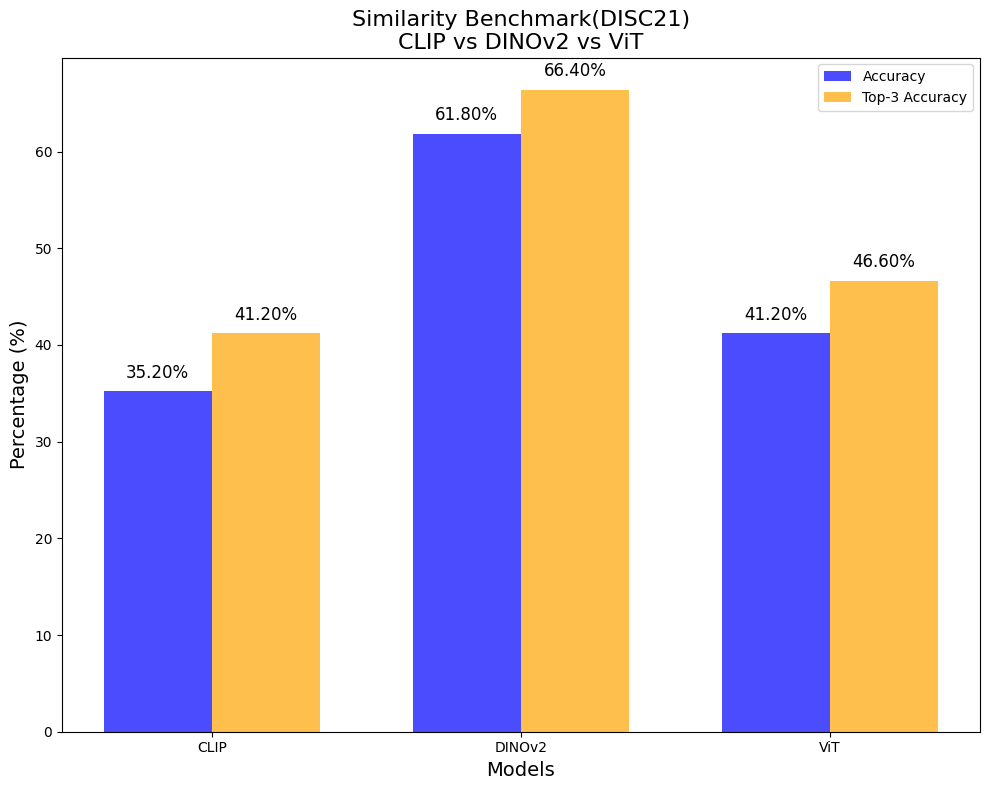

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 정의
models = ['CLIP', 'DINOv2', 'ViT']
accuracy = [100*len(clip_correct)/500, 100*len(dino_correct)/500, 100*len(vit_correct)/500]
top_3_accuracy = [100*len(clip_correct_top3)/500, 100*len(dino_correct_top3)/500, 100*len(vit_correct_top3)/500]

# x 위치 설정
x = np.arange(len(models))
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 8))

# Accuracy와 Top-3 Accuracy 막대 생성
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, top_3_accuracy, width, label='Top-3 Accuracy', color='orange', alpha=0.7)

# 제목 및 축 레이블 설정
ax.set_title('Similarity Benchmark(DISC21)\nCLIP vs DINOv2 vs ViT', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 값 표시
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

add_labels(bars1)
add_labels(bars2)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

#### compare the result

In [ ]:
all_correct = list(set(clip_correct) & set(dino_correct)&set(vit_correct))
clip_dino = list(set(clip_correct) & set(dino_correct))
clip_vit = list(set(clip_correct) & set(vit_correct))
dino_vit = list(set(dino_correct) & set(vit_correct))
only_clip = list(set(clip_correct) - set(dino_correct) - set(vit_correct))
only_dino = list(set(dino_correct) - set(clip_correct)-set(vit_correct))
only_vit = list(set(vit_correct) - set(dino_correct)-set(clip_correct))

In [ ]:
len(clip_correct), len(dino_correct), len(vit_correct)

(176, 309, 206)

In [ ]:
len(all_correct), len(clip_dino), len(clip_vit), len(dino_vit), len(only_clip), len(only_dino), len(only_vit)

(138, 167, 141, 194, 6, 86, 9)

In [ ]:
retrieved_images = [
    {"path": os.path.join(reference_folder_path,reference_list[idx]+'.jpg'), "similarity": 100 - dist* 100} for idx, dist in zip(index_list[0], distance_list[0])
]

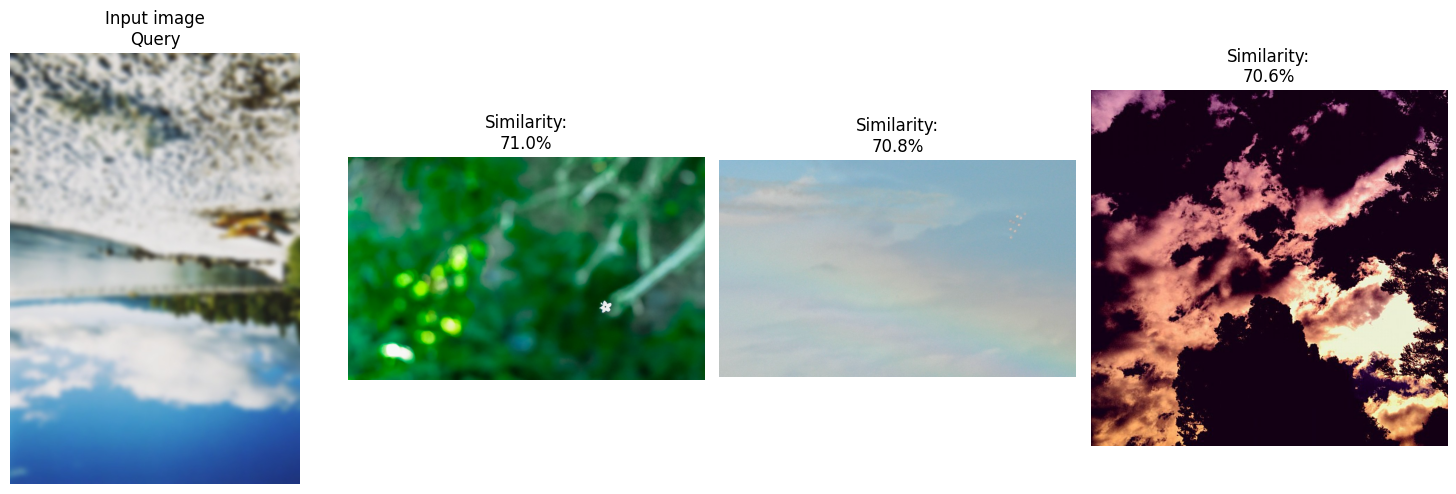

In [ ]:
def visualize_similar_images(query_image, retrieved_images):
    # 쿼리 이미지 로드

    # 설정: 시각화 크기
    fig, axes = plt.subplots(1, len(retrieved_images) + 1, figsize=(15, 5))

    # 쿼리 이미지 표시
    axes[0].imshow(query_image)
    axes[0].axis("off")
    axes[0].set_title("Input image\nQuery")

    # 검색된 이미지 표시
    for i, img_info in enumerate(retrieved_images):
        # 이미지 로드
        img = Image.open(img_info["path"]).convert("RGB")
        similarity = img_info["similarity"]

        # 이미지 표시
        axes[i + 1].imshow(img)
        axes[i + 1].axis("off")
        axes[i + 1].set_title(f"Similarity:\n{similarity:.1f}%")

    plt.tight_layout()
    plt.show()

# 5. 함수 호출
#visualize_similar_images(test_img, retrieved_images)